<a href="https://colab.research.google.com/github/piyush0511/SpellChecker-AutoCorrect/blob/main/SpellCheck%20-%20seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup


In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
import numpy as np
from tensorflow import keras
import random
import string
import pandas as pd
import re
from tqdm import tqdm
import pickle

Found GPU at: /device:GPU:0


## Download the data


In [2]:
!curl -O http://www.manythings.org/anki/fra-eng.zip
!unzip fra-eng.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6134k  100 6134k    0     0  2870k      0  0:00:02  0:00:02 --:--:-- 2870k
Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


## Configuration


In [3]:
num_samples = 120000   # Number of samples to train on.
data_path = "fra.txt"  # Path to the data txt file on disk.

In [4]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 128  # Latent dimensionality of the encoding space.
output_dim = 64


## Prepare the data


In [5]:
# Vectorize the data.
input_texts = []
target_texts = []
input_ =[]
tar_ =[]
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")

for line in lines[: min(num_samples, len(lines) - 1)]:
  for _ in range(5):
      input_text, target_text, _ = line.split("\t")
      input_text = input_text.lower()
      input_text = re.sub(r'[^a-zA-Z ]+', '', input_text)
      target_text = "\t" + input_text + "\n"
      for i in range(np.random.choice(np.arange(0, 2), p=[0.1, 0.9])):

          input_text = input_text.replace(random.choice(list(input_text)),random.choice(string.ascii_letters))

      input_texts.append(input_text.lower())
      target_texts.append(target_text)
      for char in input_text.lower():
          if char not in input_characters:
              input_characters.add(char)
      for char in target_text:
          if char not in target_characters:
              target_characters.add(char)


input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print("Number of samples:", len(input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
)
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
)

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0


Number of samples: 600000
Number of unique input tokens: 27
Number of unique output tokens: 29
Max sequence length for inputs: 31
Max sequence length for outputs: 33


In [6]:
input_token_index

{' ': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

## Build the model


In [7]:
# Define an input sequence and process it.
encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
encoder = keras.layers.LSTM(latent_dim, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)

# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Train the model


In [8]:
model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [9]:

model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=batch_size,
    epochs=15,
    validation_split=0.2,
)
# Save model
model.save("auto.h5")


Epoch 1/15
7500/7500 [==============================] - 71s 8ms/step - loss: 1.2294 - accuracy: 0.6381 - val_loss: 1.2893 - val_accuracy: 0.6174
Epoch 2/15
7500/7500 [==============================] - 62s 8ms/step - loss: 0.8818 - accuracy: 0.7402 - val_loss: 1.0788 - val_accuracy: 0.6812
Epoch 3/15
7500/7500 [==============================] - 66s 9ms/step - loss: 0.7746 - accuracy: 0.7726 - val_loss: 1.0085 - val_accuracy: 0.7066
Epoch 4/15
7500/7500 [==============================] - 63s 8ms/step - loss: 0.7146 - accuracy: 0.7911 - val_loss: 0.9537 - val_accuracy: 0.7220
Epoch 5/15
7500/7500 [==============================] - 62s 8ms/step - loss: 0.6763 - accuracy: 0.8028 - val_loss: 0.9332 - val_accuracy: 0.7281
Epoch 6/15
7500/7500 [==============================] - 63s 8ms/step - loss: 0.6476 - accuracy: 0.8115 - val_loss: 0.9177 - val_accuracy: 0.7329
Epoch 7/15
7500/7500 [==============================] - 63s 8ms/step - loss: 0.6264 - accuracy: 0.8179 - val_loss: 0.8888 - val_ac

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 27)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 29)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 128), (None, 79872       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 128),  80896       input_2[0][0]                    
                                                                 lstm[0][1]                   

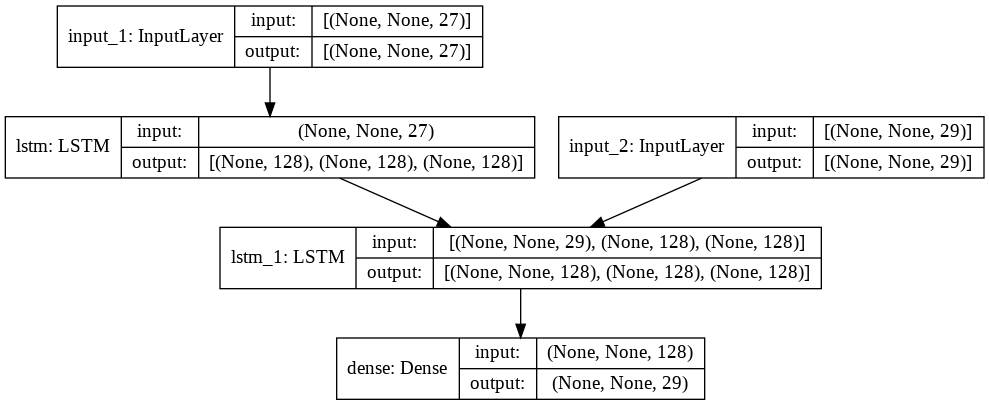

In [11]:
tf.keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)


## Run inference (sampling)

1. encode input and retrieve initial decoder state
2. run one step of decoder with this initial state
and a "start of sequence" token as target.
Output will be the next target token.
3. Repeat with the current target token and current states


In [12]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
#model = keras.models.load_model("s2s")

encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,), name="input_3")
decoder_state_input_c = keras.Input(shape=(latent_dim,), name="input_4")
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
    return decoded_sentence



You can now generate decoded sentences as such:


In [27]:
test_text = "ygu mqst leave now"

encoder_test_data = np.zeros(
    (1, max_encoder_seq_length, num_encoder_tokens), dtype="float32")

for t, char in enumerate(test_text):
    encoder_test_data[0, t, input_token_index[char]] = 1.0

decoded_sentence = decode_sequence(encoder_test_data)
print(decoded_sentence)

you must leave now



In [23]:
out = pd.DataFrame(columns = ["input", "decoded", "target"])
tt = 0
for seq_index in tqdm(range(57300, 57400)):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    out.loc[len(out.index)] = [input_texts[seq_index], decoded_sentence, target_texts[seq_index]]


100%|██████████| 100/100 [00:59<00:00,  1.68it/s]


In [15]:
out.tail(20)
#np.shape(input_seq)
#tt

,input,decoded,target
80,toa aisled you,tom asseed you\n,\ttom misled you\n
81,lom misled you,tom mished you\n,\ttom misled you\n
82,tomjmisledjyou,tom missed you\n,\ttom misled you\n
83,tqm misled yqu,tom missed you\n,\ttom misled you\n
84,tom misved you,tom missed you\n,\ttom misled you\n
85,tom misled nou,tom missed you\n,\ttom misled you\n
86,tomnmislednyou,tom wished you\n,\ttom misled you\n
87,tym misled yyu,tom mushed you\n,\ttom misled you\n
88,fom misled you,tom missed you\n,\ttom misled you\n
89,tsm misled ysu,tom mushed you\n,\ttom misled you\n


In [16]:
f = open('var.pkl','wb')
jj = {"input_token_index":input_token_index, "target_token_index":target_token_index, "num_decoder_tokens": num_decoder_tokens, "max_encoder_seq_length":max_encoder_seq_length, "num_encoder_tokens": num_encoder_tokens}
pickle.dump(jj, f)
f.close()